# 0. Setting

## 0.1. Installation

In [377]:
# !pip install python-dotenv
# !pip install python-binance

In [378]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from datetime import datetime

In [379]:
load_dotenv()

api_key = os.environ.get("API_KEY") if os.environ.get("API_KEY") else ""
api_secret = os.environ.get("API_SECRET") if os.environ.get("API_SECRET") else ""

## 0.2. Connecting API

In [380]:
import requests
import json

url = "https://api.binance.com"
api_call = "/api/v3/ticker/price"
headers = {"content-type": "application/json", "X-MBX-APIKEY": api_key}

response = requests.get(url + api_call, headers=headers)
response = json.loads(response.text)

print(response)

[{'symbol': 'ETHBTC', 'price': '0.02501000'}, {'symbol': 'LTCBTC', 'price': '0.00081900'}, {'symbol': 'BNBBTC', 'price': '0.00604500'}, {'symbol': 'NEOBTC', 'price': '0.00005280'}, {'symbol': 'QTUMETH', 'price': '0.00075900'}, {'symbol': 'EOSETH', 'price': '0.00030670'}, {'symbol': 'SNTETH', 'price': '0.00001700'}, {'symbol': 'BNTETH', 'price': '0.00020260'}, {'symbol': 'BCCBTC', 'price': '0.00000000'}, {'symbol': 'GASBTC', 'price': '0.00002650'}, {'symbol': 'BNBETH', 'price': '0.24170000'}, {'symbol': 'BTCUSDT', 'price': '111041.37000000'}, {'symbol': 'ETHUSDT', 'price': '2777.33000000'}, {'symbol': 'HSRBTC', 'price': '0.00000000'}, {'symbol': 'OAXETH', 'price': '0.00000000'}, {'symbol': 'DNTETH', 'price': '0.00000000'}, {'symbol': 'MCOETH', 'price': '0.00000000'}, {'symbol': 'ICNETH', 'price': '0.00000000'}, {'symbol': 'MCOBTC', 'price': '0.00000000'}, {'symbol': 'WTCBTC', 'price': '0.00000024'}, {'symbol': 'WTCETH', 'price': '0.00000000'}, {'symbol': 'LRCBTC', 'price': '0.00000068'}

In [381]:
df = pd.DataFrame.from_records(response)
df

,symbol,price
0,ETHBTC,0.02501000
1,LTCBTC,0.00081900
2,BNBBTC,0.00604500
3,NEOBTC,0.00005280
4,QTUMETH,0.00075900
...,...,...
3165,LAUSDC,0.45460000
3166,LABNB,0.00067970
3167,LAFDUSD,0.45500000
3168,LATRY,18.14000000


# 1. Binance API

```text
Documentation: https://developers.binance.com/docs/binance-spot-api-docs
```

In [382]:
class BinanceAPI:
    def __init__(self, api_key=None, api_secret=None):
        self.base_url = "https://api.binance.com"
        self.api_key = api_key
        self.api_secret = api_secret
        
    # ข้อมูลเทียนหรือกราฟแท่งเทียนในอดีตสำหรับคู่การเทรดที่กำหนดตาม Symbol
    def get_klines(self, symbol, interval, limit=1000, start_time=None, end_time=None):
        endpoint = "/api/v3/klines"
        params = {
            'symbol': symbol,
            'interval': interval,
            'limit': limit
        }
        
        if start_time:
            params['startTime'] = start_time
        if end_time:
            params['endTime'] = end_time
            
        response = requests.get(self.base_url + endpoint, params=params)
        return response.json()
    
    def get_n_symbol(self, n) :
        endpoint = "/api/v3/ticker/price"
        headers = {"content-type": "application/json", "X-MBX-APIKEY": self.api_key}
        response = requests.get(self.base_url + endpoint, headers=headers)
        response = json.loads(response.text)
        df = pd.DataFrame.from_records(response)
        return df.loc[:n, "symbol"] 
    
    def get_server_time(self, as_timestamp=False) :
        endpoint = "/api/v3/time"
        response = requests.get(self.base_url + endpoint)
        ts = response.json()["serverTime"]
        if as_timestamp:
            return ts
        time = datetime.fromtimestamp(ts / 1000)
        return time.strftime("%Y-%m-%d %H:%M:%S")
    
    # สถิติการเปลี่ยนแปลงราคา 24 ชั่วโมงสำหรับคู่การเทรดที่กำหนดตาม Symbol
    def get_24hr_ticker(self, symbol):
        endpoint = "/api/v3/ticker/24hr"
        params = {'symbol': symbol}
        response = requests.get(self.base_url + endpoint, params=params)
        return response.json()
    
    # ข้อมูล order book ปัจจุบันสำหรับคู่การเทรดที่กำหนดตาม Symbol
    def get_orderbook(self, symbol, limit=100):
        endpoint = "/api/v3/depth"
        params = {'symbol': symbol, 'limit': limit}
        response = requests.get(self.base_url + endpoint, params=params)
        return response.json()

In [383]:
api = BinanceAPI(api_key, api_secret)
api

In [384]:
api.get_server_time()

'2025-07-10 17:01:00'

In [385]:
api.get_n_symbol(10)

0      ETHBTC
1      LTCBTC
2      BNBBTC
3      NEOBTC
4     QTUMETH
5      EOSETH
6      SNTETH
7      BNTETH
8      BCCBTC
9      GASBTC
10     BNBETH
Name: symbol, dtype: object

In [386]:
api.get_klines("ETHBTC", "1m", limit=5)

[[1752141420000,
  '0.02500000',
  '0.02501000',
  '0.02500000',
  '0.02501000',
  '6.04050000',
  1752141479999,
  '0.15107223',
  10,
  '5.98720000',
  '0.14973973',
  '0'],
 [1752141480000,
  '0.02502000',
  '0.02503000',
  '0.02501000',
  '0.02501000',
  '3.11800000',
  1752141539999,
  '0.07801222',
  12,
  '0.21950000',
  '0.00549194',
  '0'],
 [1752141540000,
  '0.02501000',
  '0.02501000',
  '0.02501000',
  '0.02501000',
  '0.00000000',
  1752141599999,
  '0.00000000',
  0,
  '0.00000000',
  '0.00000000',
  '0'],
 [1752141600000,
  '0.02502000',
  '0.02502000',
  '0.02501000',
  '0.02501000',
  '2.08200000',
  1752141659999,
  '0.05208905',
  6,
  '1.82550000',
  '0.04567399',
  '0'],
 [1752141660000,
  '0.02501000',
  '0.02501000',
  '0.02501000',
  '0.02501000',
  '0.00000000',
  1752141719999,
  '0.00000000',
  0,
  '0.00000000',
  '0.00000000',
  '0']]

# 2. Collect Data

In [387]:
def collect_historical_data(api: BinanceAPI, symbol, interval='1m', days=1, end_time=None):
    if end_time is None:
        end_time = int(api.get_server_time(as_timestamp=True))
    start_time = end_time - (days * 24 * 60 * 60 * 1000)
    
    klines = api.get_klines(
        symbol=symbol,
        interval=interval,
        start_time=start_time,
        end_time=end_time,
    )
    
    # Convert to DataFrame
    df = pd.DataFrame(klines, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    # Convert data types
    numeric_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df.drop(["ignore"], axis=1, inplace=True)
    
    return df

In [388]:
api = BinanceAPI(api_key, api_secret)
symbol = "BNBBTC"

train_df = collect_historical_data(api, symbol, interval="5m", days=4)

test_df = collect_historical_data(api, symbol, interval="1m", days=1, end_time=None)
test_df = test_df[test_df['timestamp'] > train_df['timestamp'].max()]

In [389]:
train_df

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2025-07-06 10:05:00,0.006062,0.006067,0.006062,0.006063,47.013,2025-07-06 10:09:59.999,0.285092,59,43.82300000,0.26575292
1,2025-07-06 10:10:00,0.006062,0.006063,0.006062,0.006063,1.541,2025-07-06 10:14:59.999,0.009343,11,0.00000000,0.00000000
2,2025-07-06 10:15:00,0.006063,0.006063,0.006061,0.006061,3.954,2025-07-06 10:19:59.999,0.023970,13,0.12000000,0.00072744
3,2025-07-06 10:20:00,0.006061,0.006061,0.006060,0.006060,2.848,2025-07-06 10:24:59.999,0.017261,11,0.00000000,0.00000000
4,2025-07-06 10:25:00,0.006061,0.006061,0.006061,0.006061,0.161,2025-07-06 10:29:59.999,0.000976,3,0.16100000,0.00097581
...,...,...,...,...,...,...,...,...,...,...,...
995,2025-07-09 21:00:00,0.006019,0.006022,0.006011,0.006014,74.627,2025-07-09 21:04:59.999,0.448878,136,32.74300000,0.19693771
996,2025-07-09 21:05:00,0.006017,0.006024,0.006012,0.006021,45.729,2025-07-09 21:09:59.999,0.275223,68,29.22600000,0.17590584
997,2025-07-09 21:10:00,0.006021,0.006024,0.006014,0.006014,51.587,2025-07-09 21:14:59.999,0.310602,84,24.03300000,0.14473675
998,2025-07-09 21:15:00,0.006014,0.006016,0.006001,0.006001,51.639,2025-07-09 21:19:59.999,0.310083,120,16.60300000,0.09967457


In [390]:
test_df

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
679,2025-07-09 21:21:00,0.005997,0.005998,0.005997,0.005998,0.364,2025-07-09 21:21:59.999,0.002183,4,0.06700000,0.00040186
680,2025-07-09 21:22:00,0.005997,0.005999,0.005997,0.005999,1.618,2025-07-09 21:22:59.999,0.009706,4,0.92400000,0.00554307
681,2025-07-09 21:23:00,0.005999,0.005999,0.005998,0.005998,1.811,2025-07-09 21:23:59.999,0.010862,4,1.81100000,0.01086238
682,2025-07-09 21:24:00,0.005998,0.006000,0.005998,0.006000,3.707,2025-07-09 21:24:59.999,0.022239,7,2.66400000,0.01598109
683,2025-07-09 21:25:00,0.006000,0.006003,0.006000,0.006003,7.648,2025-07-09 21:25:59.999,0.045899,15,5.11700000,0.03071302
...,...,...,...,...,...,...,...,...,...,...,...
995,2025-07-10 02:37:00,0.006023,0.006024,0.006023,0.006024,2.419,2025-07-10 02:37:59.999,0.014572,3,2.39600000,0.01443350
996,2025-07-10 02:38:00,0.006024,0.006024,0.006024,0.006024,0.000,2025-07-10 02:38:59.999,0.000000,0,0.00000000,0.00000000
997,2025-07-10 02:39:00,0.006025,0.006025,0.006025,0.006025,0.296,2025-07-10 02:39:59.999,0.001783,1,0.00000000,0.00000000
998,2025-07-10 02:40:00,0.006025,0.006025,0.006025,0.006025,0.000,2025-07-10 02:40:59.999,0.000000,0,0.00000000,0.00000000


<b>Columns</b>

1) <b>open</b>: ราคา *แรกสุด* ที่มีการซื้อขายในช่วงเวลา t
2) <b>high</b>: ราคา *สูงสุด* ที่มีการซื้อขายในช่วงเวลา t
3) <b>low</b>: ราคา *ต่ำสุด* ที่มีการซื้อขายในช่วงเวลา t
4) <b>close</b>: ราคา *สุดท้าย* ที่มีการซื้อขายในช่วงเวลา t

``` 
4 Columns นี้มีการพิจารณาค่าตัวเลขเหมือนกัน เข่น 0.2389 คือ 1 ETH แลกได้ 0.2389 BTC 
```

---

5. <b>volume</b>: จำนวนเหรียญหลักรวมที่มีการซื้อขายในช่วงเวลา t
6. <b>quote_asset_volume</b>: จำนวนเหรียญคู่รวมที่มีการซื้อขายในช่วงเวลา t BTC รวม
7. <b>number_of_trades</b>: จำนวนครั้งที่มีการซื้อขายในช่วงเวลา t
8. <b>taker_buy_base_asset_volume</b>: จำนวนเหรียญหลักรวมที่มีการรีบซื้อในทันทีในช่วงเวลา t
9. <b>taker_buy_quote_asset_volume</b>: จำนวนเหรียญคู่รวมที่มีการรีบซื้อในทันทีในช่วงเวลา t

---

10. <b>timestamp</b>: เวลาเริ่มต้นของการซื้อขาย
11. <b>close_time</b>: เวลาสิ้นสุดของการซื้อขาย

---

In [391]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     1000 non-null   datetime64[ns]
 1   open                          1000 non-null   float64       
 2   high                          1000 non-null   float64       
 3   low                           1000 non-null   float64       
 4   close                         1000 non-null   float64       
 5   volume                        1000 non-null   float64       
 6   close_time                    1000 non-null   datetime64[ns]
 7   quote_asset_volume            1000 non-null   float64       
 8   number_of_trades              1000 non-null   int64         
 9   taker_buy_base_asset_volume   1000 non-null   object        
 10  taker_buy_quote_asset_volume  1000 non-null   object        
dtypes: datetime64[ns](2), float64(6

In [392]:
train_df["taker_buy_base_asset_volume"] = train_df["taker_buy_base_asset_volume"].astype(float)
train_df["taker_buy_quote_asset_volume"] = train_df["taker_buy_quote_asset_volume"].astype(float)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     1000 non-null   datetime64[ns]
 1   open                          1000 non-null   float64       
 2   high                          1000 non-null   float64       
 3   low                           1000 non-null   float64       
 4   close                         1000 non-null   float64       
 5   volume                        1000 non-null   float64       
 6   close_time                    1000 non-null   datetime64[ns]
 7   quote_asset_volume            1000 non-null   float64       
 8   number_of_trades              1000 non-null   int64         
 9   taker_buy_base_asset_volume   1000 non-null   float64       
 10  taker_buy_quote_asset_volume  1000 non-null   float64       
dtypes: datetime64[ns](2), float64(8

In [393]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321 entries, 679 to 999
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     321 non-null    datetime64[ns]
 1   open                          321 non-null    float64       
 2   high                          321 non-null    float64       
 3   low                           321 non-null    float64       
 4   close                         321 non-null    float64       
 5   volume                        321 non-null    float64       
 6   close_time                    321 non-null    datetime64[ns]
 7   quote_asset_volume            321 non-null    float64       
 8   number_of_trades              321 non-null    int64         
 9   taker_buy_base_asset_volume   321 non-null    object        
 10  taker_buy_quote_asset_volume  321 non-null    object        
dtypes: datetime64[ns](2), float64(6), i

In [394]:
test_df["taker_buy_base_asset_volume"] = test_df["taker_buy_base_asset_volume"].astype(float)
test_df["taker_buy_quote_asset_volume"] = test_df["taker_buy_quote_asset_volume"].astype(float)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321 entries, 679 to 999
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     321 non-null    datetime64[ns]
 1   open                          321 non-null    float64       
 2   high                          321 non-null    float64       
 3   low                           321 non-null    float64       
 4   close                         321 non-null    float64       
 5   volume                        321 non-null    float64       
 6   close_time                    321 non-null    datetime64[ns]
 7   quote_asset_volume            321 non-null    float64       
 8   number_of_trades              321 non-null    int64         
 9   taker_buy_base_asset_volume   321 non-null    float64       
 10  taker_buy_quote_asset_volume  321 non-null    float64       
dtypes: datetime64[ns](2), float64(8), i

# 3. Create Indicators

## 3.1. Moving Average

คำนวณค่าเฉลี่ยแบบเคลื่อนที่ทุกๆ n จุด แล้วดูแนวโน้มค่าเฉลี่ยเหล่านั้น

- Bullish: มีแนวโน้มว่าในอนาคต ราคาสูงขึ้น -> 1 ETH มีแนวโน้มจะได้ BTC มากขึ้น
    - ถ้าเรามี ETH อยู่ เราควรถือไว้ หรือซื้อ ETH เพิ่มเติม
    - ถ้าเรามี BTC อยู่ เราควรขายเพื่อซื้อ ETH
     
- Bearish: มีแนวโน้มว่าในอนาคต ราคาลดลง -> 1 ETH มีแนวโน้มจะได้ BTC น้อยลง
    - ถ้าเรามี ETH อยู่ เราควรขายเพื่อซื้อ BTC
    - ถ้าเรามี BTC อยู่ เราควรถือไว้ หรือซื้อ BTC เพิ่มเติม

In [395]:
def add_moving_average(df: pd.DataFrame):
    df = df.copy()
    
    price_col = "close"
    
    # SMA
    for period in [20, 50, 200]:
        df[f'SMA_{period}'] = df[price_col].rolling(period, min_periods=1).mean()
    
    # EMA   
    for period in [12, 26]:
        df[f'EMA_{period}'] = df[price_col].ewm(span=period, adjust=False).mean()
    
    # Golden Cross: 50-day SMA crosses above 200-day SMA (Long-term Bullish)
    df['golden_cross'] = ((df['SMA_50'] > df['SMA_200']) & 
                         (df['SMA_50'].shift(1) <= df['SMA_200'].shift(1))).astype(int)
    
    # Death Cross: 50-day SMA crosses below 200-day SMA (Long-term Bearish)
    df['death_cross'] = ((df['SMA_50'] < df['SMA_200']) & 
                        (df['SMA_50'].shift(1) >= df['SMA_200'].shift(1))).astype(int)
    
    # Bullish Cross: 20-day SMA crosses above 50-day SMA (Short-term Bullish)
    df['bullish_cross'] = ((df['SMA_20'] > df['SMA_50']) & 
                          (df['SMA_20'].shift(1) <= df['SMA_50'].shift(1))).astype(int)
    
    # Bearish Cross: 20-day SMA crosses below 50-day SMA (Short-term Bearish)
    df['bearish_cross'] = ((df['SMA_20'] < df['SMA_50']) & 
                          (df['SMA_20'].shift(1) >= df['SMA_50'].shift(1))).astype(int)
    
    # EMA Bullish Cross: 12-day EMA crosses above 26-day EMA (Momentum turning up)
    df['ema_bullish_cross'] = ((df['EMA_12'] > df['EMA_26']) & 
                              (df['EMA_12'].shift(1) <= df['EMA_26'].shift(1))).astype(int)
    
    # EMA Bearish Cross: 12-day EMA crosses below 26-day EMA (Momentum turning down)
    df['ema_bearish_cross'] = ((df['EMA_12'] < df['EMA_26']) & 
                              (df['EMA_12'].shift(1) >= df['EMA_26'].shift(1))).astype(int)
    
    # 0 = Very Bearish, 5 = Very Bullish
    df['trend_strength'] = ((df[price_col] > df['SMA_20']).astype(int) + 
                           (df[price_col] > df['SMA_50']).astype(int) + 
                           (df[price_col] > df['SMA_200']).astype(int) +
                           (df[price_col] > df['EMA_12']).astype(int) +
                           (df[price_col] > df['EMA_26']).astype(int))
    
    # Price Distance from MAs
    # Positive = Above MA 
    # Negative = Below MA
    df['price_sma20_dist'] = ((df[price_col] - df['SMA_20']) / df['SMA_20']).fillna(0)
    df['price_sma50_dist'] = ((df[price_col] - df['SMA_50']) / df['SMA_50']).fillna(0)
    df['price_sma200_dist'] = ((df[price_col] - df['SMA_200']) / df['SMA_200']).fillna(0)
    
    # Price Distance from EMAs
    # Positive = Above MA 
    # Negative = Below MA
    df['price_ema12_dist'] = ((df[price_col] - df['EMA_12']) / df['EMA_12']).fillna(0)
    df['price_ema26_dist'] = ((df[price_col] - df['EMA_26']) / df['EMA_26']).fillna(0)
    
    # Bullish Alignment: SMA_20 > SMA_50 > SMA_200
    df['bullish_alignment'] = ((df['SMA_20'] > df['SMA_50']) & 
                              (df['SMA_50'] > df['SMA_200'])).astype(int)
    
    return df

## 3.2. Relative Strength Index (RSI)

https://www.investopedia.com/terms/r/rsi.asp
- บ่งบอกความแรงของราคา (Momentum) ในช่วงเวลาที่กำหนด ซึ่งมักนิยมใช้ 14 วัน
- มีค่าอยู่ในช่วงระหว่าง 0 ถึง 100

พิจารณา ETHBTC
- RSI สูง (>70) = คนซื้อ ETH ด้วย BTC เยอะมาก 
    - ETH อาจแพงเกินไปที่จะซื้อตอนนี้ 
    - ตอนนี้เราควรขาย ETH และซื้อ BTC
- RSI ต่ำ (<30) = คนขาย ETH เพื่อซื้อ BTC เยอะมาก 
    - ETH อาจถูกเกินไปที่จะขายตอนนี้ 
    - ตอนนี้เราควรซื้อ ETH และขาย BTC
- RSI กลางๆ (~50) = การซื้อขาย ETH/BTC ปกติดี  
    - ตอนนี้ควรรอดูสถานการณ์ก่อน

In [396]:
def add_rsi(df:pd.DataFrame, period=14):
    
    df = df.copy()
    
    price_col='close'
    
    delta = df[price_col].diff()
    
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)
    
    # Average Gain and Loss with Exponential Moving Average
    avg_gains = gains.ewm(alpha=1/period, adjust=False).mean()
    avg_losses = losses.ewm(alpha=1/period, adjust=False).mean()
    
    # Calculate RSI
    rs = avg_gains / avg_losses
    rsi = 100 - (100 / (1 + rs))

    df['rsi'] = rsi
    
    return df

## 3.3. MACD

- ใช้ดูแนวโน้ม (trend) และโมเมนตัม (momentum) ของราคา 
- ดูจากความแตกต่างของค่าเฉลี่ยเคลื่อนที่แบบ EMA สองเส้น (fast: EMA12 ลบกับ slow: EMA26)

พิจารณา ETHBTC
- MACD > 0 แสดงว่าราคากำลังขึ้น หรือก็คือมีแนวโน้มว่าในอนาคต BTC จะมีราคาสูงขึ้น
    - ถ้าเราถือ ETH เราควรถือไว้ รอขายในอนาคต
    - ถ้าเราถือ BTC เราควรขายเพื่อซื้อ ETH
- MACD < 0 แสดงว่าราคากำลังลง หรือก็คือมีแนวโน้มว่าในอนาคต BTC จะมีราคาต่ำขึ้น
    - ถ้าเราถือ ETH เราควรขายเพื่อซื้อ BTC
    - ถ้าเราถือ BTC เราควรถือไว้ รอขายในอนาคต

** ยิ่งค่าห่างจาก 0 ยิ่งมีแนวโน้มที่จะไปทางนั้นๆ สูง

- จังหวะที่ควรซื้อ หรือขาย คือจังหวะที่เส้นของ MACD ตัดกับเส้น MACD_Signal
    - MACD ตัดแล้วขึ้นสูงกว่า MACD_Signal: เป็นช่วงราคากำลังขึ้น
    - MACD ตัดแล้วต่ำกว่า MACD_Signal: เป็นช่วงราคากำลังลง

In [397]:
def add_macd(df, fast=12, slow=26, signal=9):
    # Calculate EMA fast and slow
    df['ema_fast'] = df['close'].ewm(span=fast, adjust=False).mean()
    df['ema_slow'] = df['close'].ewm(span=slow, adjust=False).mean()
    
    # MACD line
    df['macd'] = df['ema_fast'] - df['ema_slow']
    
    # Signal line
    df['macd_signal'] = df['macd'].ewm(span=signal, adjust=False).mean()
    
    return df

## 3.4. Bollinger Bands

- ประกอบด้วย 3 เส้นหลัก:

1. เส้นกลาง (Middle Band) : SMA ของ close หมายถึงแนวโน้มราคากลาง ๆ ในช่วงเวลาที่กำหนด

2. เส้นบน (Upper Band): SMA + 2SD บ่งบอกขอบเขตราคาที่ "สูงกว่าปกติ" หรือเป็นระดับแนวต้าน

3. เส้นล่าง (Lower Band): SMA - 2SD บ่งบอกขอบเขตราคาที่ "ต่ำกว่าปกติ" หรือเป็นระดับแนวรับ

พิจารณา ETHBTC
- มี 4 Case ที่เกิดขึ้นได้
    1. Close Price ชิด Upper Band: ราคาสูงเกินไปแล้ว อาจมีโอกาสราคาตกลงในเร็ว ๆ นี้
        - ถ้าเราถือ ETH ควรขายเพื่อซื้อ BTC
        - ถ้าเราถือ BTC ควรถือไว้ รอขายในอนาคต
    2. Close Price ชิด Lower Band: ราคาต่ำเกินไปแล้ว อาจมีโอกาสราคาขึ้นในเร็ว ๆ นี้
        - ถ้าเราถือ ETH ควรถือไว้ รอขายในอนาคต
        - ถ้าเราถือ BTC ควรขายเพื่อซื้อ ETH
    3. Upper Band กับ Lower Band เข้ามาชิดกัน: ความผันผวนต่ำ เตรียมเคลื่อนไหว
        - ถ้า Close Price สูงกว่า Upper Band อาจเป็นสัญญาณซื้อ ETH ขาย BTC
        - ถ้า Close Price ต่ำกว่า Lower Band อาจเป็นสัญญาณขาย ETH ซื้อ BTC
    4. Upper Band กับ Lower Band ห่างออกจากกัน: ความผันผวนสูง
        - ถ้า Close Price สูงขึ้น และอยู่ใกล้ Upper Band ควรถือ ETH ต่อเนื่อง หรือซื้อเพิ่ม
        - ถ้า Close Price ลดลง และอยู่ใกล้ Lower Band → ควรขาย ETH ซื้อ BTC

In [398]:
def add_bollinger(df, period=20, std_dev=2):
    df['bb_middle'] = df['close'].rolling(window=period).mean()
    df['bb_std'] = df['close'].rolling(window=period).std()
    
    df['bb_upper'] = df['bb_middle'] + std_dev * df['bb_std']
    df['bb_lower'] = df['bb_middle'] - std_dev * df['bb_std']

    return df

In [399]:
def add_all_indicators(df) :
    df = add_moving_average(df)
    df = add_rsi(df)
    df = add_macd(df)
    df = add_bollinger(df)
    return df

# 4. Create Model

## EDA

In [400]:
ind_train_df = add_all_indicators(train_df)
ind_train_df.set_index("timestamp", inplace=True)

ind_test_df = add_all_indicators(test_df)
ind_test_df.set_index("timestamp", inplace=True)

In [401]:
ind_train_df

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,...,bullish_alignment,rsi,ema_fast,ema_slow,macd,macd_signal,bb_middle,bb_std,bb_upper,bb_lower
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-07-06 10:05:00,0.006062,0.006067,0.006062,0.006063,47.013,2025-07-06 10:09:59.999,0.285092,59,43.823,0.265753,...,0,NaN,0.006063,0.006063,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
2025-07-06 10:10:00,0.006062,0.006063,0.006062,0.006063,1.541,2025-07-06 10:14:59.999,0.009343,11,0.000,0.000000,...,0,NaN,0.006063,0.006063,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
2025-07-06 10:15:00,0.006063,0.006063,0.006061,0.006061,3.954,2025-07-06 10:19:59.999,0.023970,13,0.120,0.000727,...,0,0.000000,0.006063,0.006063,-1.595442e-07,-3.190883e-08,NaN,NaN,NaN,NaN
2025-07-06 10:20:00,0.006061,0.006061,0.006060,0.006060,2.848,2025-07-06 10:24:59.999,0.017261,11,0.000,0.000000,...,0,0.000000,0.006062,0.006063,-3.624971e-07,-9.802648e-08,NaN,NaN,NaN,NaN
2025-07-06 10:25:00,0.006061,0.006061,0.006061,0.006061,0.161,2025-07-06 10:29:59.999,0.000976,3,0.161,0.000976,...,0,27.374302,0.006062,0.006063,-4.376026e-07,-1.659417e-07,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-09 21:00:00,0.006019,0.006022,0.006011,0.006014,74.627,2025-07-09 21:04:59.999,0.448878,136,32.743,0.196938,...,0,39.720183,0.006022,0.006030,-7.797282e-06,-1.001103e-05,0.006018,0.000017,0.006052,0.005984
2025-07-09 21:05:00,0.006017,0.006024,0.006012,0.006021,45.729,2025-07-09 21:09:59.999,0.275223,68,29.226,0.175906,...,0,44.631616,0.006022,0.006029,-7.285235e-06,-9.465869e-06,0.006017,0.000015,0.006048,0.005986
2025-07-09 21:10:00,0.006021,0.006024,0.006014,0.006014,51.587,2025-07-09 21:14:59.999,0.310602,84,24.033,0.144737,...,0,41.031333,0.006021,0.006028,-7.359440e-06,-9.044583e-06,0.006015,0.000013,0.006040,0.005989


In [402]:
ind_test_df

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,...,bullish_alignment,rsi,ema_fast,ema_slow,macd,macd_signal,bb_middle,bb_std,bb_upper,bb_lower
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-07-09 21:21:00,0.005997,0.005998,0.005997,0.005998,0.364,2025-07-09 21:21:59.999,0.002183,4,0.067,0.000402,...,0,NaN,0.005998,0.005998,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
2025-07-09 21:22:00,0.005997,0.005999,0.005997,0.005999,1.618,2025-07-09 21:22:59.999,0.009706,4,0.924,0.005543,...,0,100.000000,0.005998,0.005998,7.977208e-08,1.595442e-08,NaN,NaN,NaN,NaN
2025-07-09 21:23:00,0.005999,0.005999,0.005998,0.005998,1.811,2025-07-09 21:23:59.999,0.010862,4,1.811,0.010862,...,0,48.148148,0.005998,0.005998,6.159041e-08,2.508161e-08,NaN,NaN,NaN,NaN
2025-07-09 21:24:00,0.005998,0.006000,0.005998,0.006000,3.707,2025-07-09 21:24:59.999,0.022239,7,2.664,0.015981,...,0,75.504711,0.005998,0.005998,2.061878e-07,6.130285e-08,NaN,NaN,NaN,NaN
2025-07-09 21:25:00,0.006000,0.006003,0.006000,0.006003,7.648,2025-07-09 21:25:59.999,0.045899,15,5.117,0.030713,...,0,86.775474,0.005999,0.005999,5.564428e-07,1.603308e-07,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-10 02:37:00,0.006023,0.006024,0.006023,0.006024,2.419,2025-07-10 02:37:59.999,0.014572,3,2.396,0.014434,...,0,61.325953,0.006022,0.006020,1.899164e-06,1.521520e-06,0.006020,0.000005,0.006029,0.006010
2025-07-10 02:38:00,0.006024,0.006024,0.006024,0.006024,0.000,2025-07-10 02:38:59.999,0.000000,0,0.000,0.000000,...,0,61.325953,0.006023,0.006021,1.889727e-06,1.595161e-06,0.006020,0.000005,0.006029,0.006011
2025-07-10 02:39:00,0.006025,0.006025,0.006025,0.006025,0.296,2025-07-10 02:39:59.999,0.001783,1,0.000,0.000000,...,0,63.762132,0.006023,0.006021,1.940570e-06,1.664243e-06,0.006021,0.000005,0.006030,0.006012


In [403]:
ind_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2025-07-06 10:05:00 to 2025-07-09 21:20:00
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   open                          1000 non-null   float64       
 1   high                          1000 non-null   float64       
 2   low                           1000 non-null   float64       
 3   close                         1000 non-null   float64       
 4   volume                        1000 non-null   float64       
 5   close_time                    1000 non-null   datetime64[ns]
 6   quote_asset_volume            1000 non-null   float64       
 7   number_of_trades              1000 non-null   int64         
 8   taker_buy_base_asset_volume   1000 non-null   float64       
 9   taker_buy_quote_asset_volume  1000 non-null   float64       
 10  SMA_20                        1000 non-null   float64       

In [404]:
ind_train_df.isna().sum()

open                             0
high                             0
low                              0
close                            0
volume                           0
close_time                       0
quote_asset_volume               0
number_of_trades                 0
taker_buy_base_asset_volume      0
taker_buy_quote_asset_volume     0
SMA_20                           0
SMA_50                           0
SMA_200                          0
EMA_12                           0
EMA_26                           0
golden_cross                     0
death_cross                      0
bullish_cross                    0
bearish_cross                    0
ema_bullish_cross                0
ema_bearish_cross                0
trend_strength                   0
price_sma20_dist                 0
price_sma50_dist                 0
price_sma200_dist                0
price_ema12_dist                 0
price_ema26_dist                 0
bullish_alignment                0
rsi                 

In [405]:
print("bb_middle\n", ind_train_df["bb_middle"])
print("bb_std\n", ind_train_df["bb_std"])
print("bb_upper\n", ind_train_df["bb_upper"])
print("bb_lower\n", ind_train_df["bb_lower"])
print("rsi\n", ind_train_df["rsi"])

bb_middle
 timestamp
2025-07-06 10:05:00         NaN
2025-07-06 10:10:00         NaN
2025-07-06 10:15:00         NaN
2025-07-06 10:20:00         NaN
2025-07-06 10:25:00         NaN
                         ...   
2025-07-09 21:00:00    0.006018
2025-07-09 21:05:00    0.006017
2025-07-09 21:10:00    0.006015
2025-07-09 21:15:00    0.006014
2025-07-09 21:20:00    0.006013
Name: bb_middle, Length: 1000, dtype: float64
bb_std
 timestamp
2025-07-06 10:05:00         NaN
2025-07-06 10:10:00         NaN
2025-07-06 10:15:00         NaN
2025-07-06 10:20:00         NaN
2025-07-06 10:25:00         NaN
                         ...   
2025-07-09 21:00:00    0.000017
2025-07-09 21:05:00    0.000015
2025-07-09 21:10:00    0.000013
2025-07-09 21:15:00    0.000013
2025-07-09 21:20:00    0.000013
Name: bb_std, Length: 1000, dtype: float64
bb_upper
 timestamp
2025-07-06 10:05:00         NaN
2025-07-06 10:10:00         NaN
2025-07-06 10:15:00         NaN
2025-07-06 10:20:00         NaN
2025-07-06 10:25:00 

In [406]:
ind_train_df.dropna(subset=['bb_lower', 'bb_upper', 'bb_middle', 'bb_std', 'rsi'], inplace=True)

In [407]:
ind_train_df.isna().sum()

open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
SMA_20                          0
SMA_50                          0
SMA_200                         0
EMA_12                          0
EMA_26                          0
golden_cross                    0
death_cross                     0
bullish_cross                   0
bearish_cross                   0
ema_bullish_cross               0
ema_bearish_cross               0
trend_strength                  0
price_sma20_dist                0
price_sma50_dist                0
price_sma200_dist               0
price_ema12_dist                0
price_ema26_dist                0
bullish_alignment               0
rsi                             0
ema_fast      

In [408]:
ind_train_df['price_direction'] = np.where(
    ind_train_df['close'].shift(-1) < ind_train_df['close'], -1, 1
)
ind_train_df['price_direction'].value_counts(normalize=True)

price_direction
 1    0.583078
-1    0.416922
Name: proportion, dtype: float64

- -1 คือ ราคาปิดในอนาคต ***น้อยกว่า*** ราคาปิดปัจจุบัน -> ในตอนนี้ควรขาย
- 1 คือ ราคาปิดในอนาคต ***มากกว่าหรือเท่ากับ*** ราคาปิดปัจจุบัน -> ในตอนนี้ควรซื้อ

In [409]:
ind_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321 entries, 2025-07-09 21:21:00 to 2025-07-10 02:41:00
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   open                          321 non-null    float64       
 1   high                          321 non-null    float64       
 2   low                           321 non-null    float64       
 3   close                         321 non-null    float64       
 4   volume                        321 non-null    float64       
 5   close_time                    321 non-null    datetime64[ns]
 6   quote_asset_volume            321 non-null    float64       
 7   number_of_trades              321 non-null    int64         
 8   taker_buy_base_asset_volume   321 non-null    float64       
 9   taker_buy_quote_asset_volume  321 non-null    float64       
 10  SMA_20                        321 non-null    float64       


In [410]:
ind_test_df.isna().sum()

open                             0
high                             0
low                              0
close                            0
volume                           0
close_time                       0
quote_asset_volume               0
number_of_trades                 0
taker_buy_base_asset_volume      0
taker_buy_quote_asset_volume     0
SMA_20                           0
SMA_50                           0
SMA_200                          0
EMA_12                           0
EMA_26                           0
golden_cross                     0
death_cross                      0
bullish_cross                    0
bearish_cross                    0
ema_bullish_cross                0
ema_bearish_cross                0
trend_strength                   0
price_sma20_dist                 0
price_sma50_dist                 0
price_sma200_dist                0
price_ema12_dist                 0
price_ema26_dist                 0
bullish_alignment                0
rsi                 

In [411]:
print("bb_middle\n", ind_test_df["bb_middle"])
print("bb_std\n", ind_test_df["bb_std"])
print("bb_upper\n", ind_test_df["bb_upper"])
print("bb_lower\n", ind_test_df["bb_lower"])
print("rsi\n", ind_test_df["rsi"])

bb_middle
 timestamp
2025-07-09 21:21:00         NaN
2025-07-09 21:22:00         NaN
2025-07-09 21:23:00         NaN
2025-07-09 21:24:00         NaN
2025-07-09 21:25:00         NaN
                         ...   
2025-07-10 02:37:00    0.006020
2025-07-10 02:38:00    0.006020
2025-07-10 02:39:00    0.006021
2025-07-10 02:40:00    0.006021
2025-07-10 02:41:00    0.006022
Name: bb_middle, Length: 321, dtype: float64
bb_std
 timestamp
2025-07-09 21:21:00         NaN
2025-07-09 21:22:00         NaN
2025-07-09 21:23:00         NaN
2025-07-09 21:24:00         NaN
2025-07-09 21:25:00         NaN
                         ...   
2025-07-10 02:37:00    0.000005
2025-07-10 02:38:00    0.000005
2025-07-10 02:39:00    0.000005
2025-07-10 02:40:00    0.000004
2025-07-10 02:41:00    0.000004
Name: bb_std, Length: 321, dtype: float64
bb_upper
 timestamp
2025-07-09 21:21:00         NaN
2025-07-09 21:22:00         NaN
2025-07-09 21:23:00         NaN
2025-07-09 21:24:00         NaN
2025-07-09 21:25:00   

In [412]:
ind_test_df.dropna(subset=['bb_lower', 'bb_upper', 'bb_middle', 'bb_std', 'rsi'], inplace=True)

In [413]:
ind_test_df.isna().sum()

open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
SMA_20                          0
SMA_50                          0
SMA_200                         0
EMA_12                          0
EMA_26                          0
golden_cross                    0
death_cross                     0
bullish_cross                   0
bearish_cross                   0
ema_bullish_cross               0
ema_bearish_cross               0
trend_strength                  0
price_sma20_dist                0
price_sma50_dist                0
price_sma200_dist               0
price_ema12_dist                0
price_ema26_dist                0
bullish_alignment               0
rsi                             0
ema_fast      

In [414]:
ind_test_df['price_direction'] = np.where(
    ind_test_df['close'].shift(-1) < ind_test_df['close'], -1, 1
)
ind_test_df['price_direction'].value_counts(normalize=True)

price_direction
 1    0.645695
-1    0.354305
Name: proportion, dtype: float64

- -1 คือ ราคาปิดในอนาคต ***น้อยกว่า*** ราคาปิดปัจจุบัน -> ในตอนนี้ควรขาย
- 1 คือ ราคาปิดในอนาคต ***มากกว่าหรือเท่ากับ*** ราคาปิดปัจจุบัน -> ในตอนนี้ควรซื้อ

## Preparing to Train Model

In [415]:
ind_train_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_12',
       'EMA_26', 'golden_cross', 'death_cross', 'bullish_cross',
       'bearish_cross', 'ema_bullish_cross', 'ema_bearish_cross',
       'trend_strength', 'price_sma20_dist', 'price_sma50_dist',
       'price_sma200_dist', 'price_ema12_dist', 'price_ema26_dist',
       'bullish_alignment', 'rsi', 'ema_fast', 'ema_slow', 'macd',
       'macd_signal', 'bb_middle', 'bb_std', 'bb_upper', 'bb_lower',
       'price_direction'],
      dtype='object')

In [416]:
ind_train_df['price_direction'].value_counts(normalize=True)

price_direction
 1    0.583078
-1    0.416922
Name: proportion, dtype: float64

In [417]:
random_state = 2025
test_size = 0.25

In [418]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

features = [
    'SMA_20', 'SMA_50', 'SMA_200',
    'EMA_12', 'EMA_26',
    'rsi', 
    'macd', 'macd_signal',
    'bb_upper', 'bb_middle', 'bb_lower',
    'trend_strength', 'price_sma20_dist', 'price_sma50_dist',
    'price_sma200_dist',
    'price_ema12_dist', 'price_ema26_dist', 'bullish_alignment'
]

target = 'price_direction'  

In [419]:
def model_evaluation(model, features, target, X_test, y_test):
    
    y_pred = model.predict(X_test)
    
    if set(np.unique(y_test)).issubset({0, 1}):
        y_pred = np.where(y_pred == 0, -1, 1)
        y_test = np.where(y_test == 0, -1, 1)
    # print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    # print("Classification Report:\n", classification_report(y_test, y_pred))
        
    accuracy = accuracy_score(y_test, y_pred)
    # print("Accuracy:", accuracy)

    precision_all = precision_score(y_test, y_pred, average=None, labels=[-1, 1])
    precision_sell = precision_all[0]
    precision_buy = precision_all[1]

    recall_all = recall_score(y_test, y_pred, average=None, labels=[-1, 1])
    recall_sell = recall_all[0]
    recall_buy = recall_all[1]

    f1_all = f1_score(y_test, y_pred, average=None, labels=[-1, 1])
    f1_sell = f1_all[0]
    f1_buy = f1_all[1]

    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)
        roc_auc = roc_auc_score(y_test, y_score)
    except Exception as e:
        roc_auc = None
    
    return {
        "model": model,
        "features": features,
        "target": target,
        "accuracy": accuracy,
        "precision_sell": precision_sell,
        "precision_buy": precision_buy,  
        "recall_sell": recall_sell,
        "recall_buy": recall_buy,
        "f1_sell": f1_sell,
        "f1_buy": f1_buy,
        "roc_auc": roc_auc
    }
    

In [420]:
def show_model_results(lr_evaluation, rf_evaluation, xgb_evaluation, knn_evaluation, svm_evaluation): 
    data = {
        "model": ["LR", "RF", "XGB", "KNN", "SVM"],
        "accuracy": [lr_evaluation["accuracy"], rf_evaluation["accuracy"], 
                    xgb_evaluation["accuracy"], knn_evaluation["accuracy"], 
                    svm_evaluation["accuracy"]],
        "precision_sell": [lr_evaluation["precision_sell"], rf_evaluation["precision_sell"],
                            xgb_evaluation["precision_sell"], knn_evaluation["precision_sell"], 
                            svm_evaluation["precision_sell"]],
        "precision_buy": [lr_evaluation["precision_buy"], rf_evaluation["precision_buy"],
                            xgb_evaluation["precision_buy"], knn_evaluation["precision_buy"],
                            svm_evaluation["precision_buy"]],
        "recall_sell": [lr_evaluation["recall_sell"], rf_evaluation["recall_sell"],
                            xgb_evaluation["recall_sell"], knn_evaluation["recall_sell"],
                            svm_evaluation["recall_sell"]],
        "recall_buy": [lr_evaluation["recall_buy"], rf_evaluation["recall_buy"],
                            xgb_evaluation["recall_buy"], knn_evaluation["recall_buy"],
                            svm_evaluation["recall_buy"]],
        "f1_sell": [lr_evaluation["f1_sell"], rf_evaluation["f1_sell"],
                        xgb_evaluation["f1_sell"], knn_evaluation["f1_sell"],
                        svm_evaluation["f1_sell"]],
        "f1_buy": [lr_evaluation["f1_buy"], rf_evaluation["f1_buy"],
                        xgb_evaluation["f1_buy"], knn_evaluation["f1_buy"],
                        svm_evaluation["f1_buy"]],
        "roc_auc": [lr_evaluation["roc_auc"], rf_evaluation["roc_auc"],
                    xgb_evaluation["roc_auc"], knn_evaluation["roc_auc"],
                    svm_evaluation["roc_auc"]]
    }
    
    results_df = pd.DataFrame(data)
    results_df.set_index("model", inplace=True)
    return results_df, {"LR": lr_evaluation["features"], "RF": rf_evaluation["features"],
                        "XGB": xgb_evaluation["features"], "KNN": knn_evaluation["features"],
                        "SVM": svm_evaluation["features"]}

## Model Training V1

### Logistic Regression

In [421]:
def lr_model_v1(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                        test_size=test_size, shuffle=False, 
                                                        random_state=random_state)
    model = LogisticRegression(random_state=random_state)
    model.fit(X_train, y_train)

    # 3. Scoring
    lr_evaluation = model_evaluation(model, features, target, X_test, y_test)
    return lr_evaluation, model

### Random Forest Classification

In [422]:
def rf_model_v1(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                        test_size=test_size, shuffle=False, 
                                                        random_state=random_state)
    model = RandomForestClassifier(random_state=random_state)
    model.fit(X_train, y_train)

    # 3. Scoring
    rf_evaluation = model_evaluation(model, features, target, X_test, y_test)
    return rf_evaluation, model

### XGBoost

In [423]:
def xgb_model_v1(df):
    X = df[features]
    y = df[target].map({-1: 0, 1: 1})
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                        test_size=test_size, shuffle=False, 
                                                        random_state=random_state)

    model = XGBClassifier(random_state=random_state)
    model.fit(X_train, y_train)

    # 3. Scoring
    xgb_evaluation = model_evaluation(model, features, target, X_test, y_test)
    return xgb_evaluation, model

### K-Nearest Neighbors

In [424]:
def knn_model_v1(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                        test_size=test_size, shuffle=False, 
                                                        random_state=random_state)
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)

    # 3. Scoring
    knn_evaluation = model_evaluation(model, features, target, X_test, y_test)
    return knn_evaluation, model

### Support Vector Machine

In [425]:
def svm_model_v1(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, 
                                                        shuffle=False, random_state=random_state)
    model = SVC(random_state=random_state)
    model.fit(X_train, y_train)

    # 3. Scoring
    svm_evaluation = model_evaluation(model, features, target, X_test, y_test)
    return svm_evaluation, model

## Model Summary V1

In [426]:
lr_evaluation, lr_model = lr_model_v1(ind_train_df)
rf_evaluation, rf_model = rf_model_v1(ind_train_df)
xgb_evaluation, xgb_model = xgb_model_v1(ind_train_df)
knn_evaluation, knn_model = knn_model_v1(ind_train_df)
svm_evaluation, svm_model = svm_model_v1(ind_train_df)

results_df_v1, result_features_v1 = show_model_results(lr_evaluation, rf_evaluation, xgb_evaluation, 
                                                       knn_evaluation, svm_evaluation)

results_df_v1

c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,accuracy,precision_sell,precision_buy,recall_sell,recall_buy,f1_sell,f1_buy,roc_auc
model,,,,,,,,
LR,0.536585,0.448276,0.548387,0.117117,0.881481,0.185714,0.676136,0.571505
RF,0.552846,0.510204,0.563452,0.225225,0.822222,0.312500,0.668675,0.556490
XGB,0.532520,0.474359,0.559524,0.333333,0.696296,0.391534,0.620462,0.493260
KNN,0.540650,0.483871,0.559783,0.270270,0.762963,0.346821,0.645768,0.518118
SVM,0.548780,0.000000,0.548780,0.000000,1.000000,0.000000,0.708661,0.603403


## Model Training V2


- เพิ่ม Hyperparameter Tuning 
- เพิ่ม SMOTE

In [427]:
from collections import Counter

features = [
    'SMA_20', 'SMA_50', 'SMA_200',
    'EMA_12', 'EMA_26',
    'rsi', 
    'macd', 'macd_signal',
    'bb_upper', 'bb_middle', 'bb_lower',
    'trend_strength', 'price_sma20_dist', 'price_sma50_dist',
    'price_sma200_dist',
    'price_ema12_dist', 'price_ema26_dist', 'bullish_alignment'
]

target = 'price_direction' 

### Logistic Regression

In [428]:
def lr_model_v2(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 3. Balance Data (SMOTE with dynamic k_neighbors)
    counter = Counter(y_train)
    min_class_count = min(counter.values())
    if min_class_count <= 1:
        X_train_res, y_train_res = X_train, y_train
    else:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # 4. Hyperparameter Tuning
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'class_weight': ['balanced']
    }
    grid = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=random_state), 
        param_grid, scoring='accuracy'
    )
    grid.fit(X_train_res, y_train_res)
    # print("Best Params:", grid.best_params_)
    # print("Best CV Score:", grid.best_score_)

    # 5. Train model
    model = LogisticRegression(max_iter=1000, **grid.best_params_, random_state=random_state)
    model.fit(X_train_res, y_train_res)

    # 6. Scoring
    lr_evaluation = model_evaluation(model, features, target, X_test, y_test)
    return lr_evaluation, model

### Random Forest Regression

In [429]:
def rf_model_v2(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 3. Balance Data (SMOTE with dynamic k_neighbors)
    counter = Counter(y_train)
    min_class_count = min(counter.values())
    if min_class_count <= 1:
        X_train_res, y_train_res = X_train, y_train
    else:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # 4. Hyperparameter Tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 8, 16, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    }

    grid = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid,
                        scoring='accuracy')
    grid.fit(X_train_res, y_train_res)
    # print("Best Params:", grid.best_params_)
    # print("Best CV Score:", grid.best_score_)

    # 5. Train model
    model = RandomForestClassifier(random_state=random_state, **grid.best_params_)
    model.fit(X_train_res, y_train_res)

    # 6. Scoring
    rf_evaluation = model_evaluation(model, features, target, X_test, y_test)
    return rf_evaluation, model

### XGBoost

In [430]:
def xgb_model_v2(df):
    X = df[features]
    y = df[target].map({-1: 0, 1: 1})
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 3. Balance Data (SMOTE with dynamic k_neighbors)
    counter = Counter(y_train)
    min_class_count = min(counter.values())
    if min_class_count <= 1:
        X_train_res, y_train_res = X_train, y_train
    else:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # 4. Hyperparameter Tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
    }

    grid = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=random_state),
        param_grid, scoring='accuracy'
    )
    grid.fit(X_train_res, y_train_res)
    # print("Best Params:", grid.best_params_)
    # print("Best CV Score:", grid.best_score_)

    # 5. Train model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        random_state=random_state, **grid.best_params_)
    model.fit(X_train_res, y_train_res)

    # 6. Scoring
    xgb_evaluation = model_evaluation(model, features, target, X_test, y_test)
    return xgb_evaluation, model

### K-Nearest Neighbors

In [431]:
def knn_model_v2(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 3. Balance Data (SMOTE with dynamic k_neighbors)
    counter = Counter(y_train)
    min_class_count = min(counter.values())
    if min_class_count <= 1:
        X_train_res, y_train_res = X_train, y_train
    else:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # 4. Hyperparameter Tuning
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
    }
    grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy')
    grid.fit(X_train_res, y_train_res)
    # print("Best Params:", grid.best_params_)
    # print("Best CV Score:", grid.best_score_)

    # 5. Train model
    model = KNeighborsClassifier(**grid.best_params_)
    model.fit(X_train_res, y_train_res)

    # 6. Scoring
    knn_evaluation = model_evaluation(model, features, target, X_test, y_test)
    return knn_evaluation, model

### Support Vector Machine

In [432]:
def svm_model_v2(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 3. Balance Data (SMOTE with dynamic k_neighbors)
    counter = Counter(y_train)
    min_class_count = min(counter.values())
    if min_class_count <= 1:
        X_train_res, y_train_res = X_train, y_train
    else:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # 4. Hyperparameter Tuning
    param_grid = {
        'C': [1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced']
    }
    grid = GridSearchCV(SVC(), param_grid, scoring='accuracy')
    grid.fit(X_train_res, y_train_res)
    # print("Best Params:", grid.best_params_)
    # print("Best CV Score:", grid.best_score_)

    # 5. Train model
    model = SVC(**grid.best_params_, random_state=random_state)
    model.fit(X_train_res, y_train_res)

    # 6. Scoring
    svm_evaluation = model_evaluation(model, features, target, X_test, y_test)
    return svm_evaluation, model

## Model Result V2

In [433]:
lr_evaluation_v2, lr_model2 = lr_model_v2(ind_train_df)
rf_evaluation_v2, rf_model2 = rf_model_v2(ind_train_df)
xgb_evaluation_v2, xgb_model2 = xgb_model_v2(ind_train_df)
knn_evaluation_v2, knn_model2 = knn_model_v2(ind_train_df)
svm_evaluation_v2, svm_model2 = svm_model_v2(ind_train_df)

results_df_v2, result_features_v2 = show_model_results(lr_evaluation_v2, 
                                                       rf_evaluation_v2, xgb_evaluation_v2, 
                                                       knn_evaluation_v2, svm_evaluation_v2)

results_df_v2

c:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:04:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,accuracy,precision_sell,precision_buy,recall_sell,recall_buy,f1_sell,f1_buy,roc_auc
model,,,,,,,,
LR,0.577236,0.536082,0.604027,0.468468,0.666667,0.500000,0.633803,0.575175
RF,0.540650,0.484375,0.560440,0.279279,0.755556,0.354286,0.643533,0.550584
XGB,0.528455,0.466667,0.555556,0.315315,0.703704,0.376344,0.620915,0.526827
KNN,0.512195,0.448276,0.547170,0.351351,0.644444,0.393939,0.591837,0.518051
SVM,0.524390,0.470588,0.562500,0.432432,0.600000,0.450704,0.580645,0.519786


## Model Training V3

- เพิ่มการทำ Dynamic Features Selection
- เพิ่ม Class Weight เพิ้มโอกาสการทาย class -1 เพราะว่าใน Data class 1 มีสัดส่วนมาก เมื่อเทียบกับ class -1

In [434]:
features = [
    'SMA_20', 'SMA_50', 'SMA_200',
    'EMA_12', 'EMA_26',
    'rsi', 
    'macd', 'macd_signal',
    'bb_upper', 'bb_middle', 'bb_lower',
    'trend_strength', 'price_sma20_dist', 'price_sma50_dist',
    'price_sma200_dist',
    'price_ema12_dist', 'price_ema26_dist', 'bullish_alignment'
]

target = 'price_direction' 

In [435]:
def get_top_features_by_coef(model, top_n=10):
    coef_abs = np.abs(model.coef_[0])
    feature_importance = pd.Series(coef_abs, index=features)
    top_feature_importance = feature_importance.sort_values(ascending=False).head(top_n)
    return top_feature_importance.index.tolist()

In [436]:
def get_top_features_by_importance(model, top_n=10):
    importances = model.feature_importances_
    feature_importance = pd.Series(importances, index=features)
    top_feature_importance = feature_importance.sort_values(ascending=False).head(top_n)
    return top_feature_importance.index.tolist()

### Logistic Regression

In [437]:
def lr_model_v3(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 3. Balance Data (SMOTE with dynamic k_neighbors)
    counter = Counter(y_train)
    min_class_count = min(counter.values())
    if min_class_count <= 1:
        X_train_res, y_train_res = X_train, y_train
    else:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # 4. Fit model ด้วย features ทั้งหมด
    model_all = LogisticRegression(max_iter=1000, random_state=random_state, class_weight='balanced')
    model_all.fit(X_train_res, y_train_res)

    # 5. เลือก top N feature
    top_features = get_top_features_by_coef(model_all)

    # 6. เตรียมข้อมูลใหม่เฉพาะ top feature
    X_top = df[top_features]
    X_top_scaled = scaler.fit_transform(X_top)
    X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
        X_top_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 7. Balance Data (SMOTE) สำหรับ top feature
    counter_top = Counter(y_train_top)
    min_class_count_top = min(counter_top.values())
    if min_class_count_top <= 1:
        X_train_res_top, y_train_res_top = X_train_top, y_train_top
    else:
        k_neighbors_top = min(5, min_class_count_top - 1)
        sm_top = SMOTE(random_state=random_state, k_neighbors=k_neighbors_top)
        X_train_res_top, y_train_res_top = sm_top.fit_resample(X_train_top, y_train_top)

    # 8. Hyperparameter Tuning
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'class_weight': [{-1: 5, 1: 1}, {-1: 2, 1: 1}, "balanced", {-1: 1, 1: 2}, {-1: 1, 1: 5}]
    }
    grid = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=random_state), 
        param_grid, scoring='accuracy'
    )
    grid.fit(X_train_res_top, y_train_res_top)

    # 9. Train model final
    model = LogisticRegression(max_iter=1000, **grid.best_params_, random_state=random_state)
    model.fit(X_train_res_top, y_train_res_top)

    lr_evaluation = model_evaluation(model, top_features, target, X_test_top, y_test_top)
    
    return lr_evaluation, model

### Random Forest Classification

In [438]:
def rf_model_v3(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 3. Balance Data (SMOTE with dynamic k_neighbors)
    counter = Counter(y_train)
    min_class_count = min(counter.values())
    if min_class_count <= 1:
        X_train_res, y_train_res = X_train, y_train
    else:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # 4. Fit model ด้วย features ทั้งหมด
    model_all = RandomForestClassifier(random_state=random_state, class_weight='balanced')
    model_all.fit(X_train_res, y_train_res)

    # 5. เลือก top N feature
    top_features = get_top_features_by_importance(model_all)

    # 6. เตรียมข้อมูลใหม่เฉพาะ top feature
    X_top = df[top_features]
    X_top_scaled = scaler.fit_transform(X_top)
    X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
        X_top_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 7. Balance Data (SMOTE) สำหรับ top feature
    counter_top = Counter(y_train_top)
    min_class_count_top = min(counter_top.values())
    if min_class_count_top <= 1:
        X_train_res_top, y_train_res_top = X_train_top, y_train_top
    else:
        k_neighbors_top = min(5, min_class_count_top - 1)
        sm_top = SMOTE(random_state=random_state, k_neighbors=k_neighbors_top)
        X_train_res_top, y_train_res_top = sm_top.fit_resample(X_train_top, y_train_top)

    # 8. Hyperparameter Tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 8, 16, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': [{-1: 5, 1: 1}, {-1: 2, 1: 1}, "balanced", {-1: 1, 1: 2}, {-1: 1, 1: 5}]
    }
    grid = GridSearchCV(
        RandomForestClassifier(random_state=random_state),
        param_grid, scoring='accuracy'
    )
    grid.fit(X_train_res_top, y_train_res_top)

    # 9. Train model final
    model = RandomForestClassifier(random_state=random_state, **grid.best_params_)
    model.fit(X_train_res_top, y_train_res_top)
    
    rf_evaluation = model_evaluation(model, top_features, target, X_test_top, y_test_top)

    return rf_evaluation, model

### XGBoost

In [439]:
def xgb_model_v3(df):
    X = df[features]
    y = df[target].map({-1: 0, 1: 1})
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 3. Balance Data (SMOTE with dynamic k_neighbors)
    counter = Counter(y_train)
    min_class_count = min(counter.values())
    if min_class_count <= 1:
        X_train_res, y_train_res = X_train, y_train
    else:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # 4. Fit model ด้วย features ทั้งหมด
    model_all = XGBClassifier(eval_metric='logloss', random_state=random_state)
    model_all.fit(X_train_res, y_train_res)

    # 5. เลือก top N feature (ถ้าเท่ากับ features ทั้งหมด ให้ลด top_n)
    top_n = 10
    top_features = get_top_features_by_importance(model_all, top_n=top_n)
    while len(top_features) == len(features) and top_n > 1:
        top_n -= 1
        top_features = get_top_features_by_importance(model_all, top_n=top_n)

    # 6. เตรียมข้อมูลใหม่เฉพาะ top feature
    X_top = df[top_features]
    scaler_top = StandardScaler()
    X_top_scaled = scaler_top.fit_transform(X_top)
    X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
        X_top_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 7. Balance Data (SMOTE) สำหรับ top feature
    counter_top = Counter(y_train_top)
    min_class_count_top = min(counter_top.values())
    if min_class_count_top <= 1:
        X_train_res_top, y_train_res_top = X_train_top, y_train_top
    else:
        k_neighbors_top = min(5, min_class_count_top - 1)
        sm_top = SMOTE(random_state=random_state, k_neighbors=k_neighbors_top)
        X_train_res_top, y_train_res_top = sm_top.fit_resample(X_train_top, y_train_top)

    # 8. Hyperparameter Tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        "scale_pos_weight": [1, 2, 5],
    }

    grid = GridSearchCV(
        XGBClassifier(eval_metric='logloss', random_state=random_state),
        param_grid, scoring='accuracy'
    )
    grid.fit(X_train_res_top, y_train_res_top)

    # 9. Train model final
    model = XGBClassifier(eval_metric='logloss', random_state=random_state, **grid.best_params_)
    model.fit(X_train_res_top, y_train_res_top)

    xgb_evaluation = model_evaluation(model, top_features, target, X_test_top, y_test_top)

    return xgb_evaluation, model

### K-Nearest Neighbors

In [440]:
def knn_model_v3(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 3. Balance Data (SMOTE with dynamic k_neighbors)
    counter = Counter(y_train)
    min_class_count = min(counter.values())
    if min_class_count <= 1:
        X_train_res, y_train_res = X_train, y_train
    else:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # 4. Fit model ด้วย features ทั้งหมด
    from sklearn.feature_selection import SelectKBest, f_classif

    top_n = 10
    selector = SelectKBest(score_func=f_classif, k=min(top_n, X_train_res.shape[1]))
    selector.fit(X_train_res, y_train_res)
    mask = selector.get_support()
    top_features = [feature for feature, selected in zip(features, mask) if selected]

    # 6. เตรียมข้อมูลใหม่เฉพาะ top feature
    X_top = df[top_features]
    X_top_scaled = scaler.fit_transform(X_top)
    X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
        X_top_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 7. Balance Data (SMOTE) สำหรับ top feature
    counter_top = Counter(y_train_top)
    min_class_count_top = min(counter_top.values())
    if min_class_count_top <= 1:
        X_train_res_top, y_train_res_top = X_train_top, y_train_top
    else:
        k_neighbors_top = min(5, min_class_count_top - 1)
        sm_top = SMOTE(random_state=random_state, k_neighbors=k_neighbors_top)
        X_train_res_top, y_train_res_top = sm_top.fit_resample(X_train_top, y_train_top)

    # 8. Hyperparameter Tuning
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        
    }
    grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy')
    grid.fit(X_train_res_top, y_train_res_top)

    # 9. Train model final
    model = KNeighborsClassifier(**grid.best_params_)
    model.fit(X_train_res_top, y_train_res_top)

    knn_evaluation = model_evaluation(model, top_features, target, X_test_top, y_test_top)

    return knn_evaluation, model

### Support Vector Machine

In [441]:
def svm_model_v3(df):
    X = df[features]
    y = df[target]
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 3. Balance Data (SMOTE with dynamic k_neighbors)
    counter = Counter(y_train)
    min_class_count = min(counter.values())
    if min_class_count <= 1:
        X_train_res, y_train_res = X_train, y_train
    else:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # 4. Fit model ด้วย features ทั้งหมด
    model_all = SVC(kernel='linear', class_weight='balanced', random_state=random_state)
    model_all.fit(X_train_res, y_train_res)

    # 5. เลือก top N feature (ใช้ absolute coef_)
    top_features = get_top_features_by_coef(model_all)

    # 6. เตรียมข้อมูลใหม่เฉพาะ top feature
    X_top = df[top_features]
    X_top_scaled = scaler.fit_transform(X_top)
    X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
        X_top_scaled, y, test_size=test_size, shuffle=False, random_state=random_state
    )

    # 7. Balance Data (SMOTE) สำหรับ top feature
    counter_top = Counter(y_train_top)
    min_class_count_top = min(counter_top.values())
    if min_class_count_top <= 1:
        X_train_res_top, y_train_res_top = X_train_top, y_train_top
    else:
        k_neighbors_top = min(5, min_class_count_top - 1)
        sm_top = SMOTE(random_state=random_state, k_neighbors=k_neighbors_top)
        X_train_res_top, y_train_res_top = sm_top.fit_resample(X_train_top, y_train_top)

    # 8. Hyperparameter Tuning
    param_grid = {
        'C': [1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'],
        'class_weight': [{-1: 5, 1: 1}, {-1: 2, 1: 1}, "balanced", {-1: 1, 1: 2}, {-1: 1, 1: 5}]
    }
    grid = GridSearchCV(SVC(), param_grid, scoring='accuracy')
    grid.fit(X_train_res_top, y_train_res_top)

    # 9. Train model final
    model = SVC(**grid.best_params_, random_state=random_state)
    model.fit(X_train_res_top, y_train_res_top)

    svm_evaluation = model_evaluation(model, top_features, target, X_test_top, y_test_top)
    return svm_evaluation, model

## Model Result V3

In [442]:
lr_evaluation_v3, lr_model3 = lr_model_v3(ind_train_df)
rf_evaluation_v3, rf_model3 = rf_model_v3(ind_train_df)
xgb_evaluation_v3, xgb_model3 = xgb_model_v3(ind_train_df)
knn_evaluation_v3, knn_model3 = knn_model_v3(ind_train_df)
svm_evaluation_v3, svm_model3 = svm_model_v3(ind_train_df)

results_df_v3, result_features_v3 = show_model_results(lr_evaluation_v3, rf_evaluation_v3, 
                                                       xgb_evaluation_v3, knn_evaluation_v3, 
                                                       svm_evaluation_v3)

results_df_v3

c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,accuracy,precision_sell,precision_buy,recall_sell,recall_buy,f1_sell,f1_buy,roc_auc
model,,,,,,,,
LR,0.447154,0.447699,0.428571,0.963964,0.022222,0.611429,0.042254,0.580781
RF,0.479675,0.459330,0.594595,0.864865,0.162963,0.600000,0.255814,0.552686
XGB,0.548780,0.000000,0.548780,0.000000,1.000000,0.000000,0.708661,0.514414
KNN,0.504065,0.444444,0.544218,0.396396,0.592593,0.419048,0.567376,0.464198
SVM,0.451220,0.451220,0.000000,1.000000,0.000000,0.621849,0.000000,0.478212


## Comparison

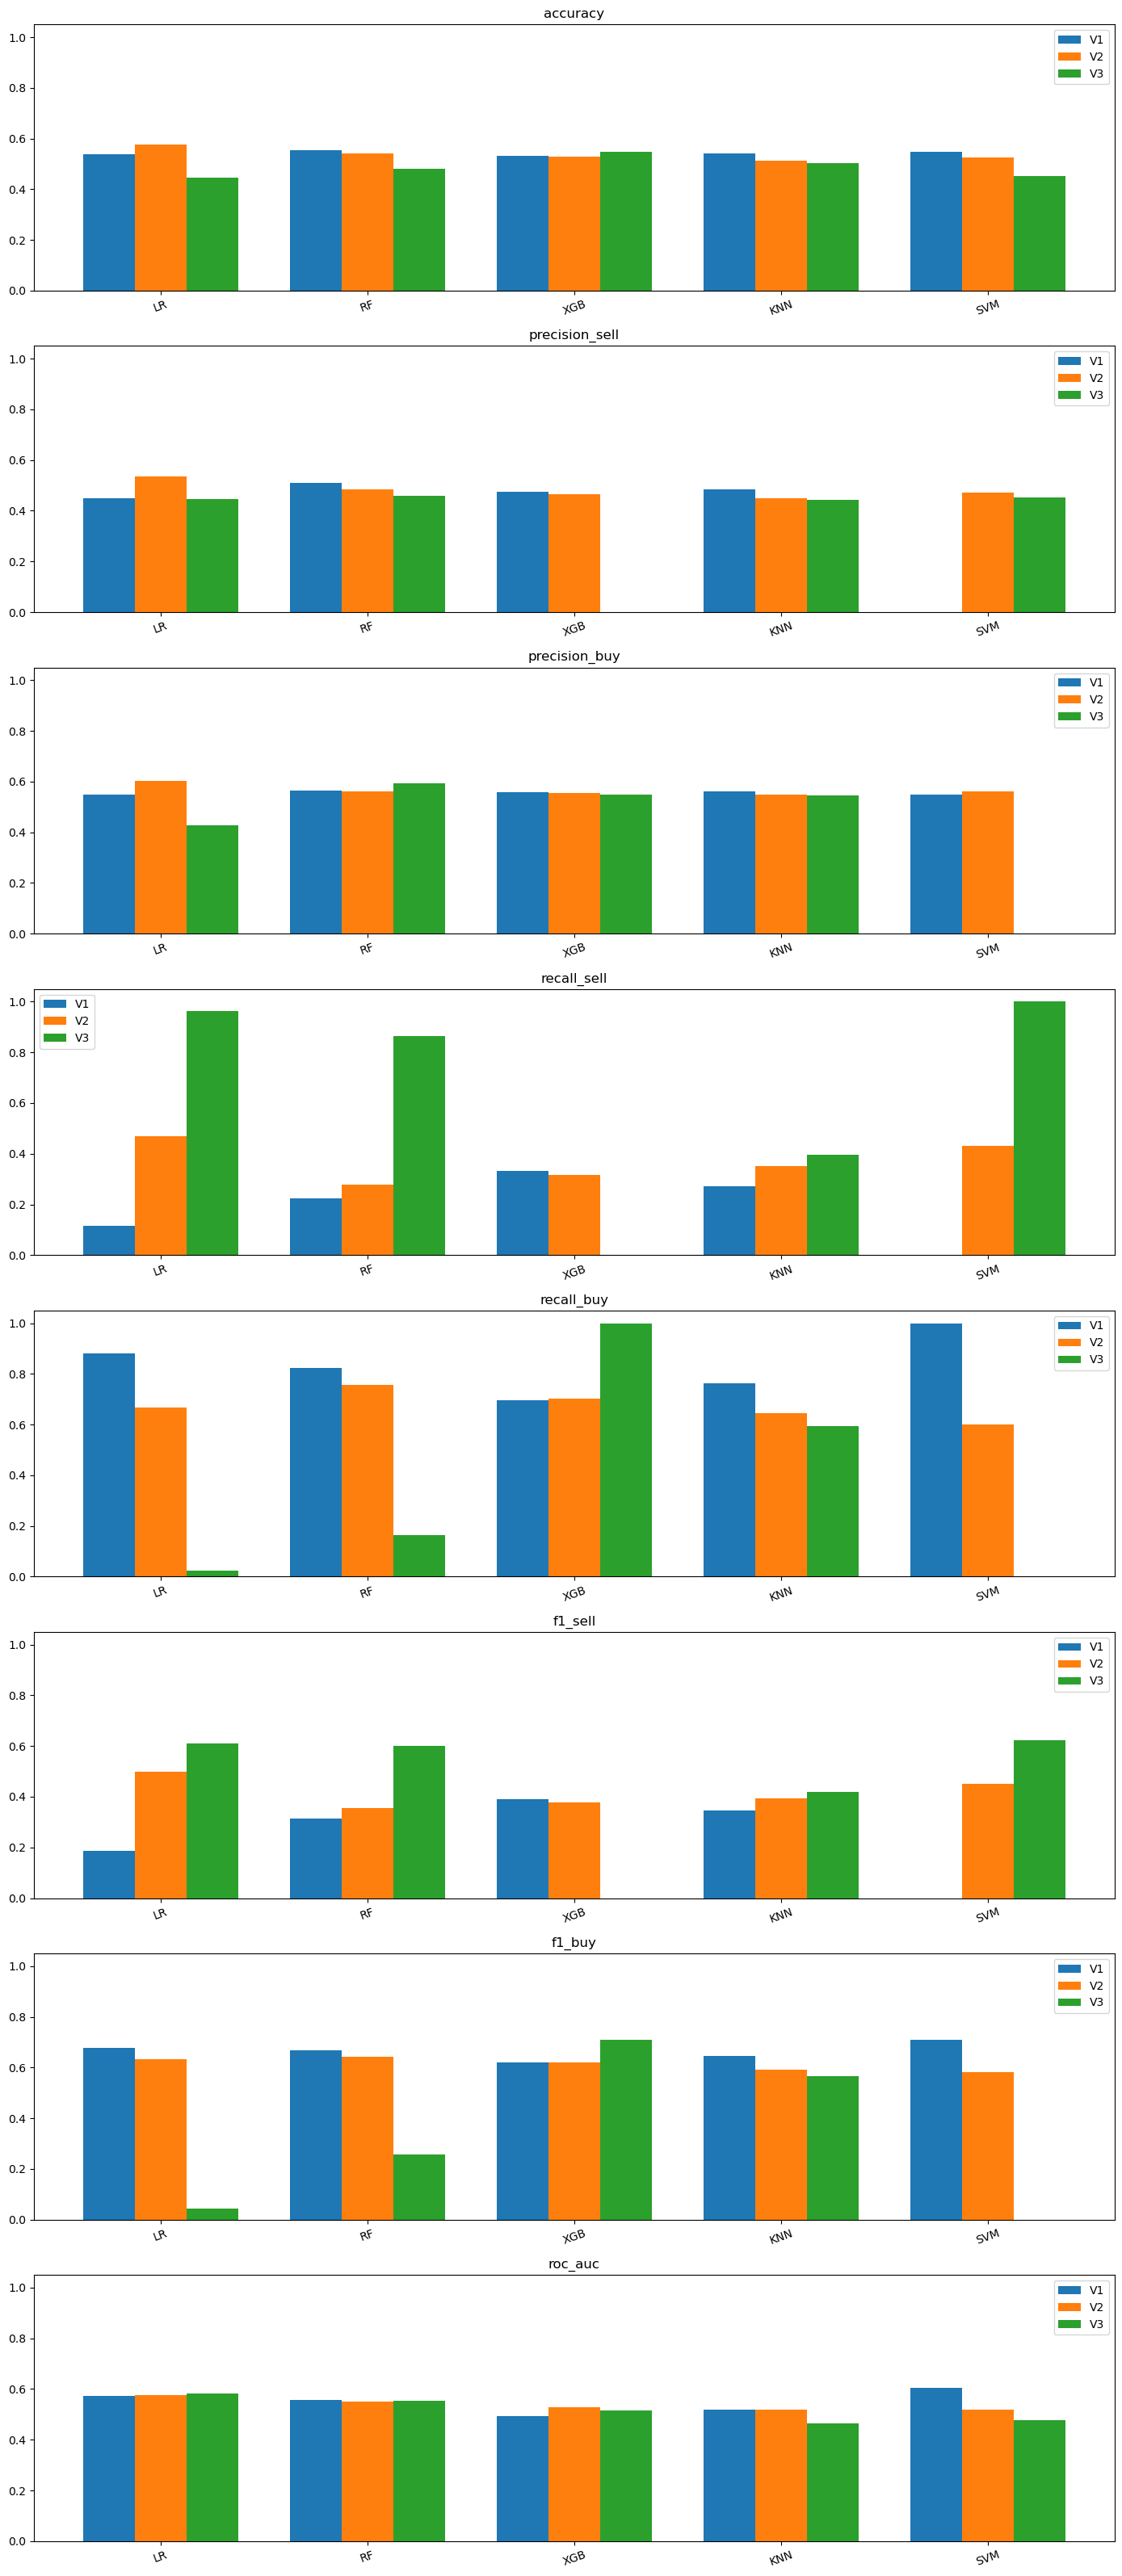

In [443]:
metrics = ['accuracy', 'precision_sell', 'precision_buy', 'recall_sell', 
           'recall_buy', 'f1_sell', 'f1_buy', 'roc_auc']

models = results_df_v1.index.tolist()
x = np.arange(len(models))
width = 0.25

fig, axes = plt.subplots(len(metrics), 1, figsize=(14, 4 * len(metrics)), sharey=True)

for i, metric in enumerate(metrics):
    axes[i].bar(x - width, results_df_v1[metric], width, label='V1')
    axes[i].bar(x, results_df_v2[metric], width, label='V2')
    axes[i].bar(x + width, results_df_v3[metric], width, label='V3')
    axes[i].set_title(metric)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(models, rotation=20)
    axes[i].legend()
    
plt.tight_layout()
plt.show()

# 5. Picking Model

ทดสอบกับหลายๆ เหรียญ แล้วหา Model ที่ดีที่สุด

In [444]:
def create_train_test_ind_df(symbol):
    api = BinanceAPI(api_key, api_secret)
    train_df = collect_historical_data(api, symbol, interval="5m", days=4)
    test_df = collect_historical_data(api, symbol, interval="1m", days=1, end_time=None)
    test_df = test_df[test_df['timestamp'] > train_df['timestamp'].max()]
    
    ind_train_df = add_all_indicators(train_df)
    ind_train_df.set_index("timestamp", inplace=True)
    ind_train_df.dropna(subset=['bb_lower', 'bb_upper', 'bb_middle', 'bb_std', 'rsi'], inplace=True)
    ind_train_df['price_direction'] = np.where(
        ind_train_df['close'].shift(-1) < ind_train_df['close'], -1, 1
    )
    
    ind_test_df = add_all_indicators(test_df)
    ind_test_df.set_index("timestamp", inplace=True)
    ind_test_df.dropna(subset=['bb_lower', 'bb_upper', 'bb_middle', 'bb_std', 'rsi'], inplace=True)
    ind_test_df['price_direction'] = np.where(
        ind_test_df['close'].shift(-1) < ind_test_df['close'], -1, 1
    )
    
    return ind_train_df, ind_test_df

In [445]:
def choose_metric_weights(buy_prop):
    if buy_prop < 0.3:
        return {'f1_buy': 0.5, 'recall_buy': 0.3, 'roc_auc': 0.2}
    elif buy_prop > 0.7:
        return {'f1_sell': 0.5, 'recall_sell': 0.3, 'roc_auc': 0.2}
    else:
        return {'f1_sell': 0.25, 'f1_buy': 0.25, 'roc_auc': 0.5}

In [446]:
def select_best_model(result_df, train_df, 
                      imbalance_threshold=0.2, 
                      severe_imbalance_penalty=0.7, 
                      mild_imbalance_penalty=0.9):
    class_counts = train_df['price_direction'].value_counts(normalize=True).sort_index()
    buy_prop = class_counts.get(1, 0.0)
    metric_weights = choose_metric_weights(buy_prop)

    def score_row(row):
        if row['recall_sell'] == 0 or row['recall_buy'] == 0:
            return -999
        score = sum(row[m] * w for m, w in metric_weights.items())
        if buy_prop < imbalance_threshold:
            score *= severe_imbalance_penalty
        elif buy_prop < 0.3:
            score *= mild_imbalance_penalty
        return score

    scores = result_df.apply(score_row, axis=1)
    best_model = scores.idxmax()
    return best_model

In [447]:
def get_best_model(ind_train_df):
    
    if ind_train_df.shape[0] != 0:
        # --- V1 ---
        lr_eval_v1, lr_model_v1_ = lr_model_v1(ind_train_df)
        rf_eval_v1, rf_model_v1_ = rf_model_v1(ind_train_df)
        xgb_eval_v1, xgb_model_v1_ = xgb_model_v1(ind_train_df)
        knn_eval_v1, knn_model_v1_ = knn_model_v1(ind_train_df)
        svm_eval_v1, svm_model_v1_ = svm_model_v1(ind_train_df)

        result_df_v1, result_features_v1 = show_model_results(
            lr_eval_v1, rf_eval_v1, xgb_eval_v1, knn_eval_v1, svm_eval_v1
        )
        result_df_v1.index = [f"{name}_V1" for name in result_df_v1.index]

        # --- V2 ---
        lr_eval_v2, lr_model_v2_ = lr_model_v2(ind_train_df)
        rf_eval_v2, rf_model_v2_ = rf_model_v2(ind_train_df)
        xgb_eval_v2, xgb_model_v2_ = xgb_model_v2(ind_train_df)
        knn_eval_v2, knn_model_v2_ = knn_model_v2(ind_train_df)
        svm_eval_v2, svm_model_v2_ = svm_model_v2(ind_train_df)

        result_df_v2, result_features_v2 = show_model_results(
            lr_eval_v2, rf_eval_v2, xgb_eval_v2, knn_eval_v2, svm_eval_v2
        )
        result_df_v2.index = [f"{name}_V2" for name in result_df_v2.index]

        # --- V3 ---
        lr_eval_v3, lr_model_v3_ = lr_model_v3(ind_train_df)
        rf_eval_v3, rf_model_v3_ = rf_model_v3(ind_train_df)
        xgb_eval_v3, xgb_model_v3_ = xgb_model_v3(ind_train_df)
        knn_eval_v3, knn_model_v3_ = knn_model_v3(ind_train_df)
        svm_eval_v3, svm_model_v3_ = svm_model_v3(ind_train_df)

        result_df_v3, result_features_v3 = show_model_results(
            lr_eval_v3, rf_eval_v3, xgb_eval_v3, knn_eval_v3, svm_eval_v3
        )
        result_df_v3.index = [f"{name}_V3" for name in result_df_v3.index]

        result_df = pd.concat([result_df_v1, result_df_v2, result_df_v3])
        best_model = select_best_model(result_df, ind_train_df)
        
        map_model = {
            "LR_V1": [lr_model_v1_, result_features_v1["LR"]],
            "LR_V2": [lr_model_v2_, result_features_v2["LR"]],
            "LR_V3": [lr_model_v3_, result_features_v3["LR"]],
            "RF_V1": [rf_model_v1_, result_features_v1["RF"]],
            "RF_V2": [rf_model_v2_, result_features_v2["RF"]],
            "RF_V3": [rf_model_v3_, result_features_v3["RF"]],
            "XGB_V1": [xgb_model_v1_, result_features_v1["XGB"]],
            "XGB_V2": [xgb_model_v2_, result_features_v2["XGB"]],
            "XGB_V3": [xgb_model_v3_, result_features_v3["XGB"]],
            "KNN_V1": [knn_model_v1_, result_features_v1["KNN"]],
            "KNN_V2": [knn_model_v2_, result_features_v2["KNN"]],
            "KNN_V3": [knn_model_v3_, result_features_v3["KNN"]],
            "SVM_V1": [svm_model_v1_, result_features_v1["SVM"]],
            "SVM_V2": [svm_model_v2_, result_features_v2["SVM"]],
            "SVM_V3": [svm_model_v3_, result_features_v3["SVM"]],
        }
        
        return map_model[best_model]

    return None

# 6. Simulation

In [448]:
def simulate(symbol=None):
    api = BinanceAPI(api_key, api_secret)
    print("Available symbols:")
    for s in api.get_n_symbol(10):
        print(s)
    if not symbol:
        # symbol = input("Symbol: ").strip().upper()
        if not symbol:
            symbol = "ETHBTC"
    print(f"\nSelected symbol: {symbol}")

    ind_train_df, ind_test_df = create_train_test_ind_df(symbol)
    if ind_train_df.shape[0] == 0 or ind_test_df.shape[0] == 0:
        print(f"{symbol} is invalid or has insufficient data. Try again")
        return

    print(f"\nTrain set size: {ind_train_df.shape}, Test set size: {ind_test_df.shape}")

    best_model, best_features = get_best_model(ind_train_df)

    x_test = ind_test_df[best_features]
    y_test = ind_test_df['price_direction']
    y_pred = best_model.predict(x_test)

    print("\n=== Test Result ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [ ]:
simulate()

Available symbols:
ETHBTC
LTCBTC
BNBBTC
NEOBTC
QTUMETH
EOSETH
SNTETH
BNTETH
BCCBTC
GASBTC
BNBETH

Selected symbol: ETHBTC

Train set size: (981, 38), Test set size: (303, 38)


c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:29:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
